<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment10/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch for best accuracy**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Preprocessing Data
<hr>

In [3]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(15),
        transforms.Normalize((0.1307,),(0.3081,))                    # 이미지를 텐서로 변형합니다.
])

transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,),(0.3081,))            
])

In [4]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform_test)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform_train)

type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  7
255


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


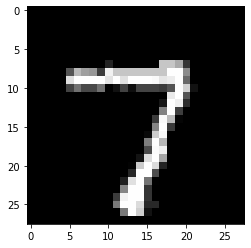

In [5]:
one_image, label = data_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
print(np.max(data_train.train_data[0].view(-1).numpy()))

In [6]:
learning_rate = 0.0015
training_epochs = 200
batch_size = 32
drop_prob = 0.5

In [7]:
train_loader = DataLoader(dataset = data_train, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader = DataLoader(dataset = data_test, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 test loader 생성

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=400, out_features=225),
            nn.BatchNorm1d(225),
            nn.ReLU(),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=225, out_features=10),
        ) 

        for m in self.modules():
          if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight.data) # Kaming He Initialization
            m.bias.data.fill_(0)                # 편차를 0으로 초기화 

    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out



In [9]:
model = classification().to(device)

In [10]:
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1, last_epoch=-1)

# 4. Training
<hr>

In [11]:
total_batch= len(train_loader)

In [12]:
print(total_batch)

313


In [13]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [14]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0
    model.train()
    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()

      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    model.eval()
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [15]:
L_train, A_train, L_test, A_test = training(model, criterion, optimizer, training_epochs, train_loader, test_loader)

Epoch: 01 Training Loss: 0.755622923 Testing Loss: 0.280405730  Training Acc: 0.752496004 Testing Acc: 0.916866660
Epoch: 02 Training Loss: 0.430110633 Testing Loss: 0.228513733  Training Acc: 0.863917708 Testing Acc: 0.931550026
Epoch: 03 Training Loss: 0.362293154 Testing Loss: 0.206482902  Training Acc: 0.885682881 Testing Acc: 0.938416660
Epoch: 04 Training Loss: 0.331663728 Testing Loss: 0.177935570  Training Acc: 0.895567060 Testing Acc: 0.946500003
Epoch: 05 Training Loss: 0.288435787 Testing Loss: 0.172011584  Training Acc: 0.908146977 Testing Acc: 0.947899997
Epoch: 06 Training Loss: 0.279735863 Testing Loss: 0.155221090  Training Acc: 0.912539899 Testing Acc: 0.953683317
Epoch: 07 Training Loss: 0.260206997 Testing Loss: 0.146618783  Training Acc: 0.916533530 Testing Acc: 0.955616653
Epoch: 08 Training Loss: 0.253630728 Testing Loss: 0.146833286  Training Acc: 0.920127749 Testing Acc: 0.955966651
Epoch: 09 Training Loss: 0.227212429 Testing Loss: 0.147214338  Training Acc: 0.

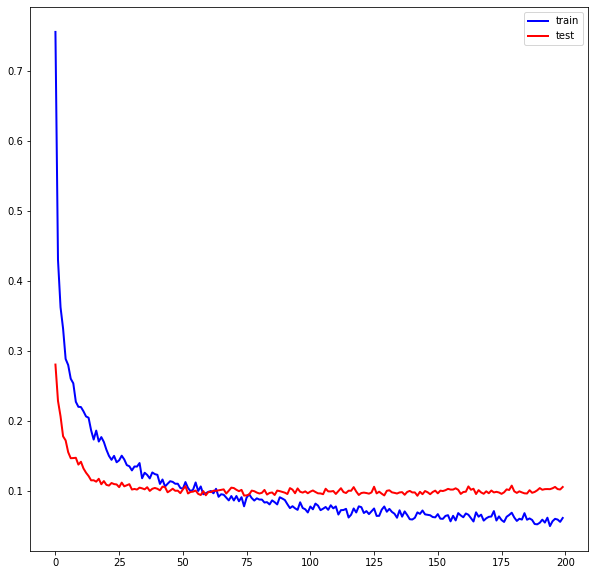

In [16]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

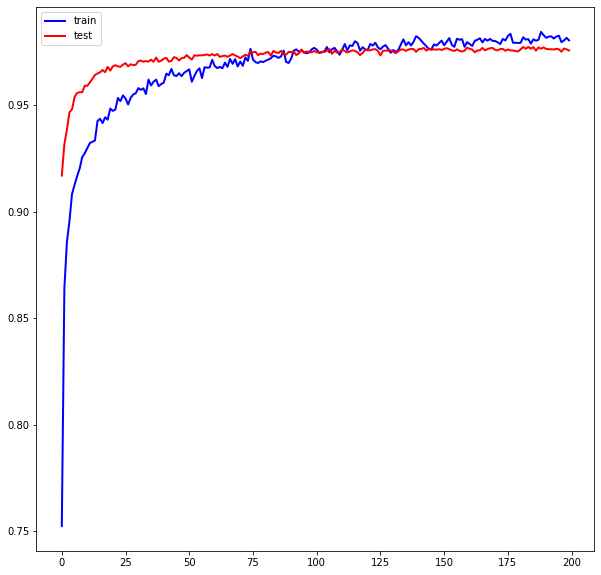

In [17]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [18]:
print("training loss    %.2f" %(L_train[-1]))
print("testing loss     %.2f" %(L_test[-1]))
print("training acc    %.2f" %(A_train[-1]))
print("testing acc     %.2f" %(A_test[-1]))

training loss    0.06
testing loss     0.11
training acc    0.98
testing acc     0.98


# 5. Output
<hr>

## 1. Plot the training and testing losses with a batch size of 32

## 2. Plot the training and testing accuracies with a batch size of 32

## 3. Plot the training and testing losses with a batch size of 64

## 4. Plot the training and testing accuracies with a batch size of 64

## 5. Plot the training and testing losses with a batch size of 128

## 6. Plot the training and testing accuracies with a batch size of 128

## 7. Print the loss at convergence with different mini-batch sizes

## 8. Print the accuracy at convergence with different mini-batch sizes